In [1]:
# 导入模块
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score,auc,confusion_matrix,f1_score,\
 precision_score, recall_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [2]:
# 准备数据
raw_data = pd.read_csv("./classification.csv",delimiter=',')
X,y = raw_data.iloc[:,:-1],raw_data.iloc[:,-1]  # 分割X,y
# 数据基本审查，查看特征数量
n_samples,n_features = X.shape
# 总的样本量，总的特征数
print('samples: {0}| features: {1} | na count: {2}'.format(n_samples, n_features,raw_data.isnull().any().count()))
# 判断所有的特征数是不是含有空值

samples: 1000| features: 41 | na count: 42


In [6]:
# 填充缺失值
X = X.fillna(X.mean())
# 样本均衡处理
# 建立SMOTE模型对象
model_smote = SMOTE()
X,y=model_smote.fit_sample(X,y)

# 填充缺失值和样本均衡
# 填充缺失值使用的是均值填充法
# 样本均衡策略用的是过抽样处理

In [7]:
# 拆分数据集
X = pd.DataFrame(X,columns=raw_data.columns[:-1])
# 划分训练集和测试机
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [8]:
# xgb 训练分类器模型
param_dist={"objective":'binary:logistic','n_estimators':10,
           'subsample':0.8,'max_depth':10,'n_jobs':-1}
model_xgb=xgb.XGBClassifier(**param_dist)
model_xgb.fit(X_train,y_train)
pre_y = model_xgb.predict(X_test)
# 参数说明
# 定义了一个dict传参
# 指定分类的对象是二元分类
# estimator数量是10个
# 每个estimator使用样本的比例是80%
# 最大深度10
# 并使用全部的CPU资

In [9]:
# 效果评估，混淆矩阵
# 获得混淆矩阵
tn,fp,fn,tp = confusion_matrix(y_test,pre_y).ravel()
pd.DataFrame([[tp,fn],[fp,tn]],columns=['prediction-0','prediction-1'],index=['action-0','action-1'])

,prediction-0,prediction-1
action-0,179,35
action-1,46,176


In [12]:
# 核心评估指标
# 获得决策树的预测概率
y_score = model_xgb.predict_proba(X_test)
# 获得决策树对每个样本点的预测概率，在ROC计算中会用到
fpr,tpr,_ = roc_curve(y_test,y_score[:,-1]) #ROC
auc_s = auc(fpr,tpr)
# 计算准确率，精确度，召回率，F1得分值
scores = [round(i(y_test,pre_y),3) for i in (accuracy_score,precision_score,\
                                            recall_score,f1_score)]
scores.insert(0,auc_s)
pd.DataFrame([scores],columns=['auc','accuracy','precision','recall','f1'])

,auc,accuracy,precision,recall,f1
0,0.891439,0.814,0.796,0.836,0.815


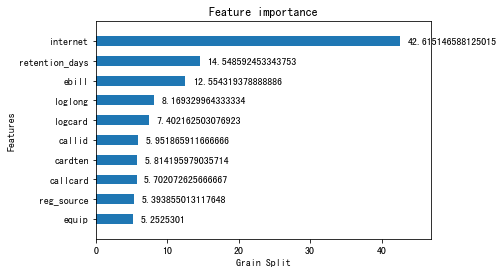

In [13]:
# 输出特征的重要性
xgb.plot_importance(model_xgb,height=0.5,importance_type='gain',max_num_features=
                   10,xlabel='Grain Split',grid=False)

# 这里一行代码直接通过plot_importance方法调用Matplotlib的接口展示图形(barh图像)，所以需要导入Matplotlib
# model_xgb：树模型对象
# height：条形图的高度
# importance_type：决定了特征重要性如何计算可选方式包括“weight”“gain”“cover”
# “weight”是特征在树中出现的次数
# “gain”是使用该特征分裂的平均增益值
# “cover”是作为分裂节点的覆盖的样本比例。
# max_num_features：设置显示的排序后最大特征的数量。
# xlabel：X轴文字
# grid：值为False设置不显示网格线

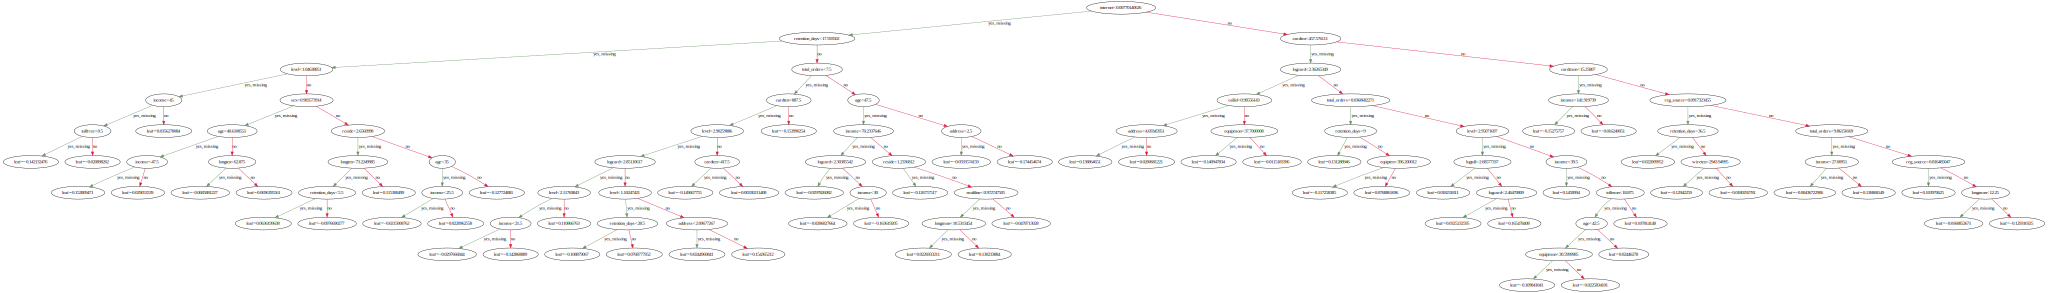

In [28]:
# 输出树形规则图
xgb.to_graphviz(model_xgb,num_trees=1,yes_color='#638e5e',no_color='#DC143C')

# 通过一行代码输出树形规则图
# model_xgb：树模型对象
# num_trees：指定要输出树的index值
# 在XGBoost的模型中，通过参数n_esti-mators指定了10个基模型（也就是10棵树），因此这里最多只能输出10个树形图，索引从0到9
# yes_color：值为真（符合条件）的线条颜色
# no_color：值为假（不符合条件）的线条颜色
# 数据中，流失标记的是1，未流失标记的是0。对应到图中就是左侧线；否则为False。那么，我们就是沿着左侧线条一直寻找即可



In [29]:
# 前N条规则对应的用户数据
rule_depth_1 = X_test['internet']<0.00284512946
rule_depth_2 = X_test['longten']<230.75
rule_depth_3 = X_test['total_orders']<2.97253799
rule_depth_4 = X_test['sex']<0.972537994
rule_depth_5 = X_test['wireten']<86.0607376
rule_list = [rule_depth_1,rule_depth_2,rule_depth_3,rule_depth_4,rule_depth_5]
rule_pd = [pd.DataFrame(i) for i in rule_list]
rule_pd_merge = pd.concat(rule_pd,axis=1)

In [30]:
# 遍历不同条件下用户的情况
for i in range(5):
    dyn_rules = rule_pd_merge.iloc[:,:i+1] # 取出top规则
    dyn_rules['is_true']=[all(i)==True for i in dyn_rules.values]
    # 得到的都是true的record
    y_test_selected = y_test[dyn_rules['is_true']]
    y_pre_selected = y_score[dyn_rules['is_true']]
    y_pre_cal = y_pre_selected[:,1] >=0.5
    total_samples=len(y_pre_cal)
    is_churn=y_pre_cal.sum()
    churn_rate = float(is_churn)/total_samples
    # 计算样本比例
    print('total samples: {}'.format(total_samples))
    print('churn samples: {} | rate: {:.0%} '.format(is_churn,churn_rate))
    print('unchurn samples: {} | rate: {:.0%} '.format((total_samples-is_churn),(1-churn_rate)))
    print('-'*40)

total samples: 216
churn samples: 48 | rate: 22% 
unchurn samples: 168 | rate: 78% 
----------------------------------------
total samples: 97
churn samples: 45 | rate: 46% 
unchurn samples: 52 | rate: 54% 
----------------------------------------
total samples: 32
churn samples: 20 | rate: 62% 
unchurn samples: 12 | rate: 38% 
----------------------------------------
total samples: 19
churn samples: 12 | rate: 63% 
unchurn samples: 7 | rate: 37% 
----------------------------------------
total samples: 16
churn samples: 10 | rate: 62% 
unchurn samples: 6 | rate: 38% 
----------------------------------------


C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
